In [3]:
!pip install kaggle

In [11]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
!cp kaggle.json ~/.kaggle/

In [13]:
!chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d rizwan123456789/potato-disease-leaf-datasetpld

 24% 9.00M/37.4M [00:00<00:00, 87.8MB/s]
100% 37.4M/37.4M [00:00<00:00, 213MB/s] 


In [15]:
!unzip potato-disease-leaf-datasetpld.zip

Archive:  potato-disease-leaf-datasetpld.zip
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_10.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_100.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_101.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_102.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_103.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_104.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_105.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_106.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_107.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_108.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_109.jpg  
  inflating: PLD_3_Classes_256/Testing/Early_Blight/Early_

In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PLD_3_Classes_256/Training',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 3251 files belonging to 3 classes.


In [18]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [19]:
class_names = dataset.class_names
class_names

['Early_Blight', 'Healthy', 'Late_Blight']

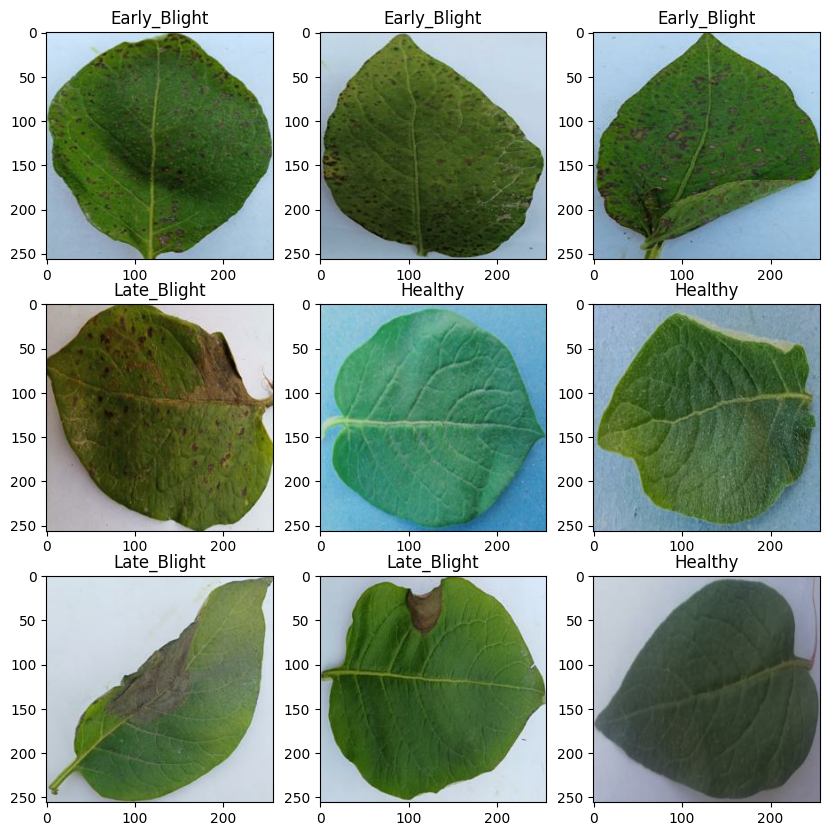

In [27]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])

In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PLD_3_Classes_256/Validation',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 416 files belonging to 3 classes.


In [29]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/PLD_3_Classes_256/Testing',
    shuffle = True,
    image_size = (256, 256),
    batch_size = 32
)

Found 405 files belonging to 3 classes.


In [30]:
len(dataset), len(val_ds), len(test_ds)

(102, 13, 13)

In [31]:
train_ds = dataset.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size= tf.data.AUTOTUNE)


In [33]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
input_shape = (32, 265, 256, 3) #(batch size, height, width, channels)
n_classes = 3
model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape= input_shape)

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [38]:
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [39]:
history = model.fit(
    train_ds,
    epochs= 70,
    batch_size= 32,
    verbose= 1,
    validation_data= val_ds
)

Epoch 1/70
102/102 [==============================] - 19s 86ms/step - loss: 1.0242 - accuracy: 0.4374 - val_loss: 0.9509 - val_accuracy: 0.4712
Epoch 2/70
102/102 [==============================] - 6s 61ms/step - loss: 0.8783 - accuracy: 0.6084 - val_loss: 0.6774 - val_accuracy: 0.7380
Epoch 3/70
102/102 [==============================] - 6s 60ms/step - loss: 0.6760 - accuracy: 0.7472 - val_loss: 0.5496 - val_accuracy: 0.7788
Epoch 4/70
102/102 [==============================] - 6s 61ms/step - loss: 0.5062 - accuracy: 0.7967 - val_loss: 0.4553 - val_accuracy: 0.8149
Epoch 5/70
102/102 [==============================] - 6s 59ms/step - loss: 0.3888 - accuracy: 0.8560 - val_loss: 0.3225 - val_accuracy: 0.8678
Epoch 6/70
102/102 [==============================] - 6s 61ms/step - loss: 0.3097 - accuracy: 0.8899 - val_loss: 0.3143 - val_accuracy: 0.8846
Epoch 7/70
102/102 [==============================] - 6s 60ms/step - loss: 0.2616 - accuracy: 0.9071 - val_loss: 0.2168 - val_accuracy: 0.913

In [40]:
score = model.evaluate(test_ds)

13/13 [==============================] - 1s 20ms/step - loss: 0.0341 - accuracy: 0.9901


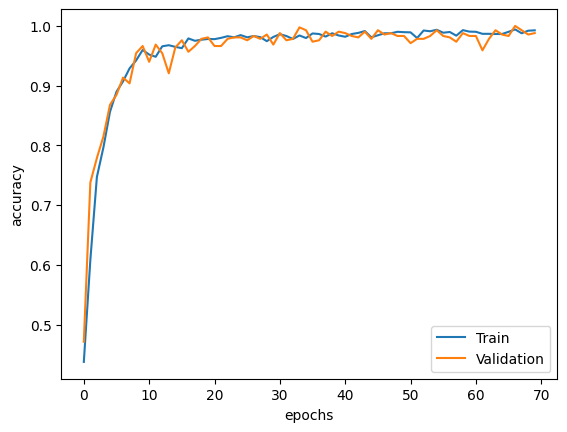

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train','Validation'])
plt.show()


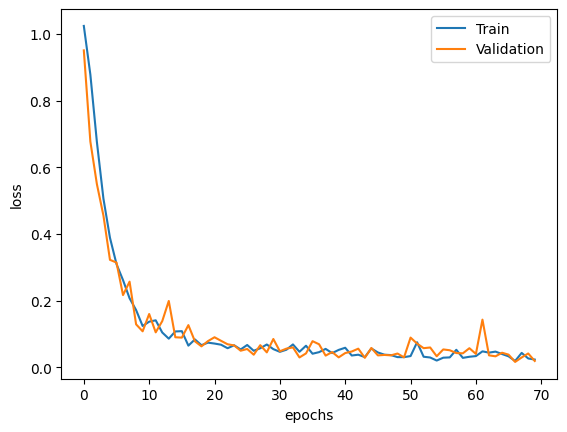

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train','Validation'])
plt.show()


In [44]:
model_version = 1.0
model.save(f'{model_version}')

In [45]:
!zip /content/model1.zip /content/1.0

  adding: content/1.0/ (stored 0%)


In [46]:
from google.colab import files
files.download("/content/model1.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>